#### 1. 라이브러리 호출

In [1]:
import sys
sys.path.append('../')

In [2]:
import os, glob, random, cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import albumentations as A

from torchvision import models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from pathlib import Path
from sklearn.manifold import TSNE

#### 2. 시드 고정

In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

#### 3. 하이퍼 파라미터 설정

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

lr = 1e-3
batch_size = 32
num_epoch = 50

mean= (0.5, 0.5, 0.5)
std= (0.5, 0.5, 0.5)
image_size = 224

In [5]:
transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#### 4. dataloader

In [6]:
# val dataloader

root_path = '/aiffel/aiffel/4. Aiffelthon/classification/'
val_path = root_path + 'dataset/val/'

# ImageFolder를 이용해 폴더명으로 class 지정
val_dataset = ImageFolder(root=val_path,
                     transform=transform_val)

# DataLoader
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

In [7]:
val_dataset.classes

['damage', 'dirt', 'normal']

In [8]:
val_dataset.class_to_idx

{'damage': 0, 'dirt': 1, 'normal': 2}

In [9]:
val_dataset.class_to_idx['damage']

0

In [10]:
val_dataset.__len__()

525

In [11]:
images, labels = next(iter(val_loader))
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#### 5. model

In [12]:
torchvision.__version__

'0.14.1+cu117'

In [13]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(in_features=1280, out_features=3)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [14]:
# model.load_state_dict(torch.load("./classification/saved/EfficientNet_B0_95.pth"))

In [15]:
model_ = nn.Sequential(*list(list(model.features.children()))) + nn.Sequential(model.avgpool)
model_.to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
from tqdm import tqdm

def model_evaluate(model, data_loader, criterion, device):
    model.eval()
    
    with torch.inference_mode():
        acc = 0
        val_loss = 0
        pred_list = []
        label_list = []

        for b_idx, (img, label) in tqdm(enumerate(data_loader), total=len(data_loader)):
            img, label = img.to(device), label.to(device)
            
            output = model_(img)

            pred_list.append(output.cpu().numpy())
            label_list.append(label.cpu().numpy())
    return pred_list, label_list

In [17]:
pred_list, label_list=model_evaluate(model_, val_loader, criterion, device)

100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


In [18]:
label = torch.tensor(label_list).view(-1)
label.shape

/tmp/ipykernel_3719/1514493814.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  label = torch.tensor(label_list).view(-1)


torch.Size([512])

In [19]:
output = torch.tensor(pred_list).view(512, -1)
output

tensor([[-0.0570, -0.0058,  0.3841,  ..., -0.0855, -0.1125,  0.9001],
        [ 0.8205,  1.0960,  0.5292,  ..., -0.1053, -0.1065,  0.0310],
        [-0.0615, -0.1019,  0.0156,  ..., -0.1613, -0.1287, -0.1690],
        ...,
        [-0.1804,  0.3067,  0.0049,  ...,  0.0064, -0.0799, -0.0264],
        [ 0.0999,  1.3296,  0.1245,  ..., -0.1622, -0.1604, -0.0820],
        [ 0.0694,  0.2991, -0.1217,  ..., -0.1551, -0.0157,  0.0120]])

In [20]:
label.shape, output.shape

(torch.Size([512]), torch.Size([512, 1280]))

#### TSNE 분석

In [21]:
from sklearn.manifold import TSNE

n_componenets = 2
tsne = TSNE(n_components=n_componenets, n_iter=1500, random_state=0)

In [22]:
cluster = np.array(tsne.fit_transform(np.array(output)))

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [23]:
actual = np.array(label)

In [24]:
cluster

array([[ -7.4977865,  -2.403286 ],
       [ 15.493895 , -19.7976   ],
       [ 12.897469 ,  -3.625971 ],
       ...,
       [  8.877631 ,   4.7203555],
       [  4.2171183,  20.266768 ],
       [ -1.7730048,   2.6780431]], dtype=float32)

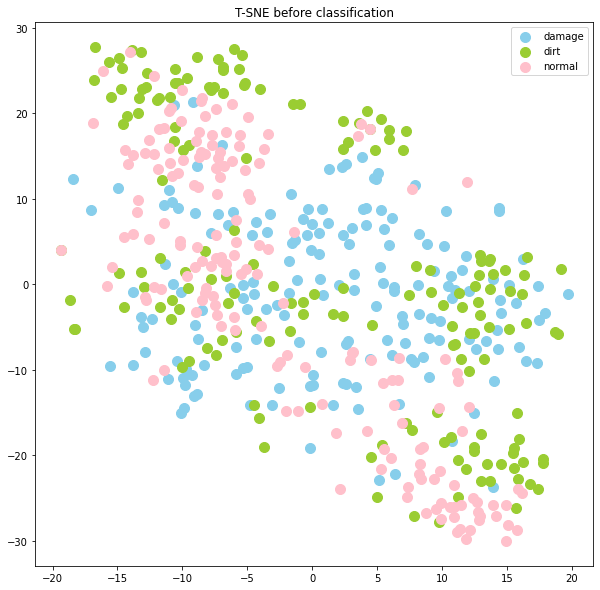

In [25]:
plt.figure(figsize=(10, 10))

damage = ['damage', 'dirt', 'normal']
color = ['skyblue', 'yellowgreen', 'pink']

for i, label in zip(range(3), damage):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], label=label, color=color[i], s=100)
    
plt.title('T-SNE before classification')
plt.legend()
# plt.savefig(f'./classification/T-SNE_before.png', dpi=200)